# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 4 - RNN



**Harvard University**<br/>
**Spring 2019**<br/>
**Instructors**: Mark Glickman and Pavlos Protopapas 


<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

<span style="color:red">**Model training can be very slow; start doing this HW early**</span>

- To submit your assignment follow the instructions given in Canvas.

- This homework can be submitted in pairs.

- If you submit individually but you have worked with someone, please include the name of your **one** partner below.
- Please restart the kernel and run the entire notebook again before you submit.

**Names of person you have worked with goes here:**
<br><BR>

<div class="theme"> Overview: Named Entity Recognition Challenge</div>

Named entity recognition (NER) seeks to locate and classify named entities present in unstructured text into predefined categories such as organizations, locations, expressions of times, names of persons, etc. This technique is often used in real use cases such as classifying content for news providers, efficient search algorithms over large corpora and content-based recommendation systems. 

This represents an interesting "many-to-many" problem, allowing us to experiment with recurrent architectures and compare their performances against other models.


In [2]:
import pandas as pd
import numpy as np

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA


import matplotlib.pyplot as plt
plt.style.use("ggplot")


In [3]:
import keras
import tensorflow as tf

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical,np_utils
from keras import backend

from keras.models import Model, Input, Sequential,model_from_json
from keras.layers import SimpleRNN, Embedding, Dense, TimeDistributed, GRU, \
                         Dropout, Bidirectional, Conv1D, BatchNormalization

print(keras.__version__)
print(tf.__version__)

Using TensorFlow backend.


2.2.4
1.12.0


In [4]:
# Set seed for repeatable results
np.random.seed(123)
tf.set_random_seed(456)

<div class='explication'> </div>


## Part 1: Read the data

Read in data ```HW4_data.csv``` and use the  code below to open the csv as a pandas dataframe.

As you can see, we have a dataset with sentences (```Sentence #``` column), each composed of words (```Word``` column) with part-of-speech tagging (```POS``` tagging) and inside–outside–beginning (IOB) named entity tags (```Tag``` column) attached. ```POS``` will not be used for this homework. We will predict ```Tag``` using only the words themselves.

Essential info about entities:
* geo = Geographical Entity
* org = Organization
* per = Person
* gpe = Geopolitical Entity
* tim = Time indicator
* art = Artifact
* eve = Event
* nat = Natural Phenomenon

IOB prefix:
* B: beginning of named entity
* I: inside of named entity
* O: outside of named entity

In [5]:
# Given code
path_dataset = './data/HW4_data.csv'
data = pd.read_csv(path_dataset, encoding="latin1")
data = data.fillna(method="ffill")
data.head(15)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


<div class='exercise'><b> Question 1.  Prepare Data [20pt]</b></div>


<span class='sub-q'> **Question 1.1**</span> 
* (1) Create a list of unique words found in column 'Word'
* (2) Sort the list in alphabetic order
* (3) Append the special word "ENDPAD" to the end of the list, and store it to a variable ```words```
* (4) Store the length of this list to a variable ```n_words```

<div class='explication'> </div>

In [27]:
# your code #
# (1) Unique Words
unique_words = list(data['Word'].unique())
# (2) Sort alphabetically
unique_words.sort()
print('First ten items in the sorted list:\n%s'%unique_words[:10])
# (3) Append 'ENDPAD'
unique_words.append('ENDPAD')
display(unique_words[-1:])
# (4) Length
n_words = len(unique_words)
print('Number of unique words: %s'%n_words)

First ten items in the sorted list:
['!', '"', '#', '#NAME?', '$', '%', '%-plus', '&', "'", "'70s"]


['ENDPAD']

Number of unique words: 35179


<span class='sub-q'>**Question 1.2**</span>
* (1) Store a list of unique tags into a variable ```tags```, paying attention to sort the list in alphabetic order
* (2) Append the special tag "PAD" to the end of the list
* (3) Store the length of this list to a variable ```n_tags```

<div class='explication'> </div>

In [32]:
# your code #
# (1)
tags = list(data['Tag'].unique())
tags.sort()
print('First ten items in the sorted list:\n%s'%tags[:10])
# (2) Append 'PAD'
tags.append('PAD')
display(tags[-1:])
# (3) Length 
n_tags = len(tags)
print('Number of unique tags: %s'%n_tags)

First ten items in the sorted list:
['B-art', 'B-eve', 'B-geo', 'B-gpe', 'B-nat', 'B-org', 'B-per', 'B-tim', 'I-art', 'I-eve']


['PAD']

Number of unique tags: 18


<span class='sub-q'>**Question 1.3**</span>
* (1) Process data into a list of sentences, each sentence is a list of (word, tag) tuples.

**Example**

First sentence in the list of sentences:

[('Thousands', 'O'),
 ('of',  'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]
* (2) Find out the number of words in the longest sentence, and store it to variable ```max_len```


<div class='explication'> </div>

In [88]:
data_gb = data.groupby(by='Sentence #')

In [89]:
d = data[data['Sentence #']=='Sentence: 1']
list(zip(d['Word'], d['Tag']))

[('Thousands', 'O'),
 ('of', 'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]

In [83]:
for s in list(data['Sentence #'].unique()):
    print(data[data['Sentence #']==s])

     Sentence #           Word  POS    Tag
0   Sentence: 1      Thousands  NNS      O
1   Sentence: 1             of   IN      O
2   Sentence: 1  demonstrators  NNS      O
3   Sentence: 1           have  VBP      O
4   Sentence: 1        marched  VBN      O
5   Sentence: 1        through   IN      O
6   Sentence: 1         London  NNP  B-geo
7   Sentence: 1             to   TO      O
8   Sentence: 1        protest   VB      O
9   Sentence: 1            the   DT      O
10  Sentence: 1            war   NN      O
11  Sentence: 1             in   IN      O
12  Sentence: 1           Iraq  NNP  B-geo
13  Sentence: 1            and   CC      O
14  Sentence: 1         demand   VB      O
15  Sentence: 1            the   DT      O
16  Sentence: 1     withdrawal   NN      O
17  Sentence: 1             of   IN      O
18  Sentence: 1        British   JJ  B-gpe
19  Sentence: 1         troops  NNS      O
20  Sentence: 1           from   IN      O
21  Sentence: 1           that   DT      O
22  Sentenc

       Sentence #         Word   POS    Tag
267  Sentence: 13         Iran   NNP  B-gpe
268  Sentence: 13           's   POS      O
269  Sentence: 13          new    JJ      O
270  Sentence: 13    President   NNP  B-per
271  Sentence: 13      Mahmoud   NNP  I-per
272  Sentence: 13  Ahmadinejad   NNP  I-per
273  Sentence: 13         said   VBD      O
274  Sentence: 13      Tuesday   NNP  B-tim
275  Sentence: 13         that    IN      O
276  Sentence: 13     European    JJ  B-gpe
277  Sentence: 13   incentives   NNS      O
278  Sentence: 13        aimed   VBN      O
279  Sentence: 13           at    IN      O
280  Sentence: 13   persuading   VBG      O
281  Sentence: 13         Iran   NNP  B-gpe
282  Sentence: 13           to    TO      O
283  Sentence: 13          end    VB      O
284  Sentence: 13          its  PRP$      O
285  Sentence: 13      nuclear    JJ      O
286  Sentence: 13         fuel    NN      O
287  Sentence: 13      program    NN      O
288  Sentence: 13          are  

       Sentence #       Word  POS    Tag
472  Sentence: 21      Local   JJ      O
473  Sentence: 21       news   NN      O
474  Sentence: 21    reports  NNS      O
475  Sentence: 21       said  VBD      O
476  Sentence: 21         at   IN      O
477  Sentence: 21      least  JJS      O
478  Sentence: 21       five   CD      O
479  Sentence: 21     mortar   NN      O
480  Sentence: 21     shells  NNS      O
481  Sentence: 21        hit  VBD      O
482  Sentence: 21        the   DT      O
483  Sentence: 21     palace   NN      O
484  Sentence: 21   compound   NN      O
485  Sentence: 21        and   CC      O
486  Sentence: 21      other   JJ      O
487  Sentence: 21    mortars  NNS      O
488  Sentence: 21       were  VBD      O
489  Sentence: 21      fired  VBN      O
490  Sentence: 21  elsewhere   RB      O
491  Sentence: 21         in   IN      O
492  Sentence: 21  Mogadishu  NNP  B-geo
493  Sentence: 21  Wednesday  NNP  B-tim
494  Sentence: 21          .    .      O
       Sentence 

       Sentence #         Word   POS    Tag
717  Sentence: 32          The    DT      O
718  Sentence: 32       Muslim   NNP  B-org
719  Sentence: 32  Brotherhood   NNP  I-org
720  Sentence: 32          has   VBZ      O
721  Sentence: 32      tripled   VBN      O
722  Sentence: 32          its  PRP$      O
723  Sentence: 32     strength    NN      O
724  Sentence: 32           in    IN      O
725  Sentence: 32   parliament    NN      O
726  Sentence: 32           in    IN      O
727  Sentence: 32       recent    JJ      O
728  Sentence: 32    elections   NNS      O
729  Sentence: 32            ,     ,      O
730  Sentence: 32      raising   VBG      O
731  Sentence: 32          the    DT      O
732  Sentence: 32        party    NN      O
733  Sentence: 32           's   POS      O
734  Sentence: 32        total    NN      O
735  Sentence: 32           to    TO      O
736  Sentence: 32           47    CD      O
737  Sentence: 32        seats   NNS      O
738  Sentence: 32            .  

       Sentence #         Word  POS    Tag
920  Sentence: 40          The   DT      O
921  Sentence: 40   opposition   NN      O
922  Sentence: 40          has  VBZ      O
923  Sentence: 40    denounced  VBN      O
924  Sentence: 40          the   DT      O
925  Sentence: 40      measure   NN      O
926  Sentence: 40            ,    ,      O
927  Sentence: 40    comparing  VBG      O
928  Sentence: 40           it  PRP      O
929  Sentence: 40           to   TO      O
930  Sentence: 40          the   DT      O
931  Sentence: 40    draconian   JJ      O
932  Sentence: 40         rule   NN      O
933  Sentence: 40           of   IN      O
934  Sentence: 40          the   DT      O
935  Sentence: 40       former   JJ      O
936  Sentence: 40      Taleban  NNP  B-org
937  Sentence: 40           in   IN      O
938  Sentence: 40  neighboring  VBG      O
939  Sentence: 40  Afghanistan  NNP  B-geo
940  Sentence: 40            .    .      O
       Sentence #           Word  POS    Tag
941  Sent

        Sentence #    Word   POS Tag
1125  Sentence: 48     His  PRP$   O
1126  Sentence: 48  driver    NN   O
1127  Sentence: 48     and    CC   O
1128  Sentence: 48       a    DT   O
1129  Sentence: 48  tribal    JJ   O
1130  Sentence: 48   elder    NN   O
1131  Sentence: 48    were   VBD   O
1132  Sentence: 48    also    RB   O
1133  Sentence: 48  killed   VBN   O
1134  Sentence: 48       .     .   O
        Sentence #            Word  POS Tag
1135  Sentence: 49              No   DT   O
1136  Sentence: 49             one   NN   O
1137  Sentence: 49             has  VBZ   O
1138  Sentence: 49         claimed  VBN   O
1139  Sentence: 49  responsibility   NN   O
1140  Sentence: 49             for   IN   O
1141  Sentence: 49             the   DT   O
1142  Sentence: 49        killings  NNS   O
1143  Sentence: 49               .    .   O
        Sentence #        Word  POS    Tag
1144  Sentence: 50         The   DT      O
1145  Sentence: 50      ambush   NN      O
1146  Sentence: 50      

        Sentence #           Word  POS    Tag
1394  Sentence: 60        Critics  NNS      O
1395  Sentence: 60             of   IN      O
1396  Sentence: 60    Halliburton  NNP  B-org
1397  Sentence: 60        include  VBP      O
1398  Sentence: 60       auditors  NNS      O
1399  Sentence: 60            and   CC      O
1400  Sentence: 60  congressional   JJ      O
1401  Sentence: 60      Democrats  NNS      O
1402  Sentence: 60              .    .      O
        Sentence #      Word  POS Tag
1403  Sentence: 61      They  PRP   O
1404  Sentence: 61       say  VBP   O
1405  Sentence: 61       the   DT   O
1406  Sentence: 61   company   NN   O
1407  Sentence: 61       has  VBZ   O
1408  Sentence: 61  produced  VBN   O
1409  Sentence: 61      some   DT   O
1410  Sentence: 61    shoddy   JJ   O
1411  Sentence: 61      work   NN   O
1412  Sentence: 61       and   CC   O
1413  Sentence: 61   charges  VBZ   O
1414  Sentence: 61       too   RB   O
1415  Sentence: 61      much   JJ   O
1416  Se

        Sentence #         Word  POS    Tag
1652  Sentence: 72           It  PRP      O
1653  Sentence: 72          was  VBD      O
1654  Sentence: 72         made  VBN      O
1655  Sentence: 72            a   DT      O
1656  Sentence: 72    permanent   JJ      O
1657  Sentence: 72         body   NN      O
1658  Sentence: 72           in   IN      O
1659  Sentence: 72         1995   CD  B-tim
1660  Sentence: 72           to   TO      O
1661  Sentence: 72      provide   VB      O
1662  Sentence: 72           an   DT      O
1663  Sentence: 72  independent   JJ      O
1664  Sentence: 72     business   NN      O
1665  Sentence: 72  perspective   NN      O
1666  Sentence: 72       within   IN      O
1667  Sentence: 72         APEC  NNP  B-org
1668  Sentence: 72            .    .      O
        Sentence #        Word  POS Tag
1669  Sentence: 73     Members  NNS   O
1670  Sentence: 73   represent  VBP   O
1671  Sentence: 73           a   DT   O
1672  Sentence: 73       range   NN   O
1673  Se

        Sentence #         Word  POS    Tag
1837  Sentence: 80        Sudan  NNP  B-gpe
1838  Sentence: 80           's  POS      O
1839  Sentence: 80   government   NN      O
1840  Sentence: 80         says  VBZ      O
1841  Sentence: 80           it  PRP      O
1842  Sentence: 80         will   MD      O
1843  Sentence: 80        order   VB      O
1844  Sentence: 80       troops  NNS      O
1845  Sentence: 80           to   TO      O
1846  Sentence: 80          end   VB      O
1847  Sentence: 80      attacks  NNS      O
1848  Sentence: 80  immediately   RB      O
1849  Sentence: 80           in   IN      O
1850  Sentence: 80       Darfur  NNP  B-geo
1851  Sentence: 80            ,    ,      O
1852  Sentence: 80          and   CC      O
1853  Sentence: 80           is  VBZ      O
1854  Sentence: 80       asking  VBG      O
1855  Sentence: 80       rebels  NNS      O
1856  Sentence: 80           to   TO      O
1857  Sentence: 80           do   VB      O
1858  Sentence: 80          the 

KeyboardInterrupt: 

In [91]:
# your code #
sentence_list = {}
for s in list(data['Sentence #'].unique()):
    d = data[data['Sentence #']==s]
    sentence = list(zip(d['Word'], d['Tag']))
    sentence_list[s] = sentence

KeyboardInterrupt: 

In [93]:
len(sentence_list)

2207

In [ ]:
# Run this cell to show your results #
print(max_len)

<span class='sub-q'>**Question 1.4**</span>

It's now time to convert the sentences data in a suitable format for the RNNs training/evaluation procedures. To this end, you are required to:
* (1) Create a ```word2idx``` dictionary mapping distinct words from the dataset into distinct integers. Also create a ```idx2word``` dictionary. 
* (2) Prepare the predictors matrix ```X```, as a list of lists, where each inner list is a sequence of words mapped into integers accordly to the ```word2idx``` dictionary. 
* (3) Apply the keras ```pad_sequences``` function to standardize the predictors. You should retrieve a matrix with all padded sentences and length equal to ```max_len``` previously computed. The dimensionality should therefore be equal to ```[# of sentences, max_len]```

Your ```X[i]``` now should be something similar to this:

```[ 8193 27727 31033 33289 22577 33464 23723 16665 33464 31142 31319 28267
 27700 33246 28646 16052    21 16915 17349  7924 32879 32985 18238 23555
    24 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]```
 
* (4) Create a ```tag2idx``` dictionary mapping distinct named entity tags from the dataset into distinct integers. Also create a ```idx2tag``` dictionary.

* (5) Prepare targets matrix ```Y```, as a list of lists,where each inner list is a sequence of tags mapped into integers accordly to the ```tag2idx``` dictionary.
* (6) apply the keras ```pad_sequences``` function to standardize the targets. Inject the ```PAD``` tag for the padding words. You should retrieve a matrix with all padded sentences'tags and length equal to ```max_length``` previously computed. 

* (7) Use the ```to_categorical``` keras function to one-hot encode the tags.

Now your ```Y``` should have dimension ```[# of sentences, max_len, n_tags]```

* (8) Split the dataset in train and test datasets (test 10%).

<div class='explication'> </div>

In [ ]:
# your code #

In [ ]:
# Run this cell to show your results #
print("The index of word 'Harvard' is: {}\n".format(word2idx["Harvard"]))
print("Sentence 1: {}\n".format(X[1]))
print(X.shape)

In [ ]:
# Run this cell to show your results #
print("The index of tag 'B-gpe' is: {}\n".format(tag2idx["B-gpe"]))
print("The tag of the last word in Sentence 1: {}\n".format(y[0][-1]))
print(np.array(y).shape)

## Part 2: Modelling

After preparing the train and test sets, we are ready to build five models: 
* frequency-based baseline 
* vanilla feedforward neural network
* recurrent neural network
* gated recurrent neural network
* bidirectional gated recurrent neural network

More details are given about architecture in each model's section. The input/output dimensionalities will be the same for all models:
* input: ```[# of sentences, max_len]```
* output: ```[# of sentences, max_len, n_tags]```

Follow the information in each model's section to set up the architecture of each model. And the end of each training, use the given ```store_model``` function to store the weights and architectures in the ```./models``` path for later testing;```load_keras_model()``` is also provided to you

A further ```plot_training_history``` helper function is given in case you need to check the training history.


In [19]:
# Store model
def store_keras_model(model, model_name):
    model_json = model.to_json() # serialize model to JSON
    with open("./models/{}.json".format(model_name), "w") as json_file:
        json_file.write(model_json)
    model.save_weights("./models/{}.h5".format(model_name)) # serialize weights to HDF5
    print("Saved model to disk")
    
# Plot history
def plot_training_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1,len(loss)+1)

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

In [20]:
# Load model 
def load_keras_model(model_name):
    # Load json and create model
    json_file = open('./models/{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # Load weights into new model
    model.load_weights("./models/{}.h5".format(model_name))
    return model

<div class='exercise'><b>Question 2: Models [40pt]</b></div>

<span class='sub-q'>**Question 2.1**</span>

### Model 1: Baseline Model ###

Predict the tag of a word simply with the most frequently-seen named entity tag of this word from the training set.

e.g. word "Apple" appears 10 times in the training set; 7 times it was tagged as "Corporate" and 3 times it was tagged as "Fruit". If we encounter the word "Apple" in the test set, we predict it as "Corporate".

**Create an np.array ```baseline``` of length [n_words]**
where the ith element   ```baseline[i]``` is the index of the most commonly seen named entity tag of word i summarised from training set.   (e.g. [16, 16, 16, ..., 0, 16, 16])




<div class='explication'> </div>

In [ ]:
# your code #

In [ ]:
# Run this cell to show your results #

print(baseline[X].shape,'\n')
print('Sentence:\n {}\n'.format([idx2word[w] for w in X[0]]))
print('Predicted Tags:\n {}'.format([idx2tag[i] for i in np.argmax(baseline[X[0]],axis=-1)]))

### Model 2: Vanilla Feed Forward Neural Network ###

This model is provided to you. Please pay attention to the architecture of this neural network, especially the input/output dimensionalities and the Embedding layer.



<span class='sub-q'>**Question 2.2**</span>

(1) Explain what is embedding layer and why we need it here.

(2) Explain why the Param # of Embedding layer is 1758950 (as shown in ```print(model.summary())```).

### Hyperparameters shared with other NN models

In [23]:
n_units = 100
drop_rate = .1
dim_embed = 50

optimizer = "rmsprop"
loss = "categorical_crossentropy"
metrics = ["accuracy"]

batch_size = 32
epochs = 10
validation_split = 0.1
verbose = 1

In [37]:
# use clear_session to start a new model #
backend.clear_session()

# Define model
model=Sequential()
model.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(Dropout(drop_rate))
model.add(Dense(n_tags, activation="softmax"))

# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [38]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_1 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 104, 18)           918       
Total params: 1,759,868
Trainable params: 1,759,868
Non-trainable params: 0
_________________________________________________________________
None


In [39]:
# Train model
history = model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Train on 38846 samples, validate on 4317 samples
Epoch 1/10
38846/38846 [==============================] - 35s 910us/step - loss: 0.3234 - acc: 0.9775 - val_loss: 0.0601 - val_acc: 0.9860
Epoch 2/10
38846/38846 [==============================] - 35s 894us/step - loss: 0.0512 - acc: 0.9864 - val_loss: 0.0476 - val_acc: 0.9869
Epoch 3/10
38846/38846 [==============================] - 39s 1ms/step - loss: 0.0450 - acc: 0.9872 - val_loss: 0.0447 - val_acc: 0.9875
Epoch 4/10
38846/38846 [==============================] - 33s 842us/step - loss: 0.0428 - acc: 0.9878 - val_loss: 0.0434 - val_acc: 0.9878
Epoch 5/10
38846/38846 [==============================] - 34s 866us/step - loss: 0.0415 - acc: 0.9881 - val_loss: 0.0427 - val_acc: 0.9880
Epoch 6/10
38846/38846 [==============================] - 42s 1ms/step - loss: 0.0407 - acc: 0.9884 - val_loss: 0.0424 - val_acc: 0.9881
Epoch 7/10
38846/38846 [==============================] - 48s 1ms/step - loss: 0.0401 - acc: 0.9885 - val_loss: 0.0420 - 

In [40]:
store_keras_model(model, 'model_FFNN')

Saved model to disk


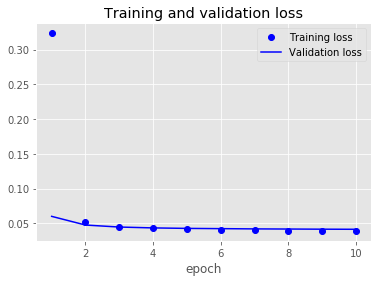

In [41]:
plot_training_history(history)

In addition to the final result, we also want to see the intermediate results from hidden layers. Below is an example showing how to get outputs from a hidden layer, and visualize them on the reduced dimension of 2D by PCA. (**Please note that these codes and parameters cannot be simply copied and pasted for other questions; some adjustments need to be made**) 

In [39]:
FFNN=load_keras_model('model_FFNN')

def create_truncated_model_FFNN(trained_model):
    model=Sequential()
    model.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
    model.add(Dropout(drop_rate))
    # set weights of first few layers using the weights of trained model
    for i, layer in enumerate(model.layers):
        layer.set_weights(trained_model.layers[i].get_weights())
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model
truncated_model = create_truncated_model_FFNN(FFNN)
hidden_features = truncated_model.predict(X_te)

# flatten data
hidden_features=hidden_features.reshape(-1,50)
y_te=y_te.reshape(-1,18)
 
# find first two PCA components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(hidden_features)
print('Variance explained by PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))

Variance explained by PCA: 0.9377351792703703


In [26]:
# visualize hidden featurs on first two PCA components
# this plot only shows B-tags
def visualize_hidden_features(pca_result):
    color=['r', 'C1', 'y', 'C3', 'b', 'g', 'm', 'orange']
    category = np.argmax(y_te, axis=1)
    fig, ax = plt.subplots()
    fig.set_size_inches(6,6)    
    for cat in range(8):
        indices_B = np.where(category==cat)[0]
        #length=min(1000,len(indices_B))
        #indices_B=indices_B[:length]
        ax.scatter(pca_result[indices_B,0], pca_result[indices_B, 1], label=idx2tag[cat],s=2,color=color[cat],alpha=0.5)
        legend=ax.legend(markerscale=3)
        legend.get_frame().set_facecolor('w')  
    plt.show()

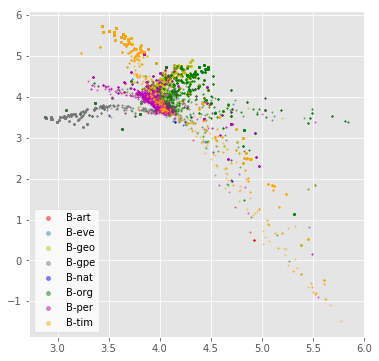

In [40]:
visualize_hidden_features(pca_result)

### Model 3: RNN ###
<span class='sub-q'>**Question 2.3**</span>

(1) Set up a simple RNN model by stacking the following layers in sequence:
* an input layer
* a simple Embedding layer transforming integer words into vectors 
* a dropout layer to regularize the model
* a SimpleRNN layer 
* a TimeDistributed layer with an inner Dense layer which output dimensionality is equal to n_tag

(2) Compile the model

(3) Train the model and plot the training history

(4) Visualize outputs from SimpleRNN layer, one subplot for **B-tags** and one subplot for **I-tags**,comment on the patterns you observed.

For hyperparameters use those provided in Model 2

<div class='explication'> </div>

In [ ]:
# your code #

In [ ]:
# save your mode ##
store_keras_model(model, 'model_RNN')

In [ ]:
# run this cell to show your results #
print(model.summary())

In [ ]:
# run this cell to show your results #
plot_training_history(history)

In [ ]:
# visualization of hidden features

<div class='explication'> </div>

### Model 4: GRU ###

<span class='sub-q'>**Question 2.4**</span>


(1) Briefly explain what is GRU and how it is different from simple RNN

(2) build a GRU architecture by replacing the SimpleRNN cell with a GRU one. 

(3) Compile the model

(4) Train the model and plot the training history

(5) Visualize outputs from GRU layer, one subplot for **B-tags** and one subplot for **I-tags**, comment on the patterns you observed.

<div class='explication'> </div>

In [ ]:
# your code #

In [ ]:
# save your model #
store_keras_model(model, 'model_GRU')

In [ ]:
# run this cell to show your results #
print(model.summary())

In [ ]:
# run this cell to show your results #
plot_training_history(history)

In [ ]:
# visualization of hidden features

<div class='explication'> </div>

### Model 5: Bidirectional GRU ###
<span class='sub-q'>**Question 2.5**</span>


(1) Explain what is Bidirectional GRU and how it is different from GRU model above.

(2) Then build a bidirectional GRU by wrapping your GRU layer into a Bidirectional one

(3) Compile the model

(4) Train the model and plot the training history

(5) Visualize outputs from bidirectional GRU layer, one subplot for **B-tags** and one subplot for **I-tags**, comment on the patterns you observed.

<div class='explication'> </div>

In [ ]:
# your code #

In [ ]:
# save your model #
store_keras_model(model, 'model_BiGRU')

In [ ]:
# run this cell to show your results #
print(model.summary())

In [ ]:
# run this cell to show your results #
plot_training_history(history)

In [ ]:
# visualization of hidden features

<div class='exercise'><b> Question 3: Analysis [40pt]</b></div>


<span class='sub-q'>**Question 3.1**</span>


For each model iteratively:

(1) Load the model using the given function ```load_keras_model```

(2) Apply the model to the test dataset

(3) Compute an F1 score for each ```Tag``` and store it 

(4) Plot the F1 score per Tag and per model making use of a grouped barplot.

(5) Briefly discuss the performance of each model

<span class='sub-q'>**Question 3.2**</span>

(1) Which tags have the lowest f1 score? 

For instance, you may find from the plot above that the test accuracy on "B-art", and "I-art" are very low (just an example, your case maybe different). Here is an example when models failed to predict these tags right

<img src="./data/B_art.png" alt="drawing" width="600"/>


(2) Write functions to output another example in which the tags of the lowest accuracy was predicted wrong in a sentence (include both "B-xxx" and "I-xxx" tags). Store the results in a DataFrame (same format as the above example) and use styling functions below to print out your df.

In [ ]:
def highlight_errors(s):
    is_max = s == s.y_true
    return ['' if v or key=='Word' else 'color: red' for key,v in is_max.iteritems()]

In [2]:
# run this cell to show you result #
your_df.style.apply(highlight_errors, axis=1)

<span class='sub-q'>**Question 3.3**</span>

(1) Choose one of the most promising models you have built, improve this model to achieve the f1 score higher than 0.8 for as many tags as possible ( you have lots of options here, e.g. data balancing, hyperparameter tuning, changing the structure of NN, a different optimizer, ... )

(2) Explain why you choose to change certain elements of the model and how effective those adjustments are.
